<a href="https://colab.research.google.com/github/DAN-BIWOTT/Arasaka-TradingSystems/blob/main/Ensembled_SVR_%26_SFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skl2onnx onnxruntime
!pip install --upgrade onnx

# Import Data Set

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re

In [3]:
from google.colab import drive, files
drive.mount('/content/drive') # mount your google colab file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filename_in_drive = "/content/drive/My Drive/Forex/Market Data USDJPY before 2025.05.17.csv"
data = pd.read_csv(filename_in_drive)
# Version Number
model_version = "3.1"
# Extract date from filename_in_drive
match = re.search(r'\b(\d{4}\.\d{2}\.\d{2})\b', filename_in_drive)
if match:
    extracted_date = match.group(1)
else:
    print("No date found in the filename.")
data.head(3)

,Time,Open,High,Low,Close,Volume
0,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
1,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
2,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0


In [5]:
num_rows = len(data)
num_rows

100001

In [6]:
data = data[::-1]
# Reduce the dataset to the first 10,000 rows because
data = data.head(10000)
original_data = data.copy()

data.head(3)

,Time,Open,High,Low,Close,Volume
100000,2025.05.16 23:00:00,145.953,145.953,145.618,145.623,2344
99999,2025.05.16 22:00:00,145.890,145.976,145.819,145.950,1915
99998,2025.05.16 21:00:00,145.909,145.923,145.821,145.888,2011


In [7]:
num_rows = len(data)
num_rows

10000

In [8]:
data.tail()

,Time,Open,High,Low,Close,Volume
90005,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
90004,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
90003,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
90002,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
90001,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 100000 to 90001
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  object 
 1   Open    10000 non-null  float64
 2   High    10000 non-null  float64
 3   Low     10000 non-null  float64
 4   Close   10000 non-null  float64
 5   Volume  10000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 468.9+ KB


In [10]:
#Define the forecast horizon
look_ahead = 1

In [11]:
#Calculate the median, which is the midpoint between the high and low prices.
data['Candlestick_Median'] = (data['High'] + data['Low']) / 2

data.head()

,Time,Open,High,Low,Close,Volume,Candlestick_Median
100000,2025.05.16 23:00:00,145.953,145.953,145.618,145.623,2344,145.7855
99999,2025.05.16 22:00:00,145.890,145.976,145.819,145.950,1915,145.8975
99998,2025.05.16 21:00:00,145.909,145.923,145.821,145.888,2011,145.8720
99997,2025.05.16 20:00:00,145.931,146.022,145.888,145.907,1948,145.9550
99996,2025.05.16 19:00:00,146.013,146.091,145.847,145.929,3054,145.9690


In [12]:
data['Candlestick_Median'] = data['Candlestick_Median'].shift(-1)
data = data.rename(columns={'Candlestick_Median': 'Future_Median'})
data['Price_Difference'] = data['High'] - data['Low']
data['Open_Close_Change_Pct'] = (data['Close'] - data['Open']) / data['Open'] * 100
data['High_Low_Change_Pct'] = (data['High'] - data['Low']) / data['Low'] * 100
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean() # 20-period moving average of volume
data['Volume_Change_Pct'] = data['Volume'].pct_change() * 100 # Percentage change in volume

In [13]:
# Rolling standard deviations
data['Volatility_StdDev_7'] = data['Close'].rolling(window=7).std()
data['Volatility_StdDev_14'] = data['Close'].rolling(window=14).std()
data['Volatility_StdDev_21'] = data['Close'].rolling(window=21).std()

# True Range and ATR calculation
tr1 = data['High'] - data['Low']
tr2 = abs(data['High'] - data['Close'].shift(1))
tr3 = abs(data['Low'] - data['Close'].shift(1))

data['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
data['ATR_14'] = data['TR'].rolling(window=14).mean()

# View recent values
data[['Close', 'Volatility_StdDev_7', 'Volatility_StdDev_14', 'Volatility_StdDev_21', 'ATR_14']].tail()


,Close,Volatility_StdDev_7,Volatility_StdDev_14,Volatility_StdDev_21,ATR_14
90005,0.0,0.0,0.0,0.0,0.0
90004,0.0,0.0,0.0,0.0,0.0
90003,0.0,0.0,0.0,0.0,0.0
90002,0.0,0.0,0.0,0.0,0.0
90001,0.0,0.0,0.0,0.0,0.0


In [14]:
data.head()

,Time,Open,High,Low,Close,Volume,Future_Median,Price_Difference,Open_Close_Change_Pct,High_Low_Change_Pct,Volume_MA_20,Volume_Change_Pct,Volatility_StdDev_7,Volatility_StdDev_14,Volatility_StdDev_21,TR,ATR_14
100000,2025.05.16 23:00:00,145.953,145.953,145.618,145.623,2344,145.8975,0.335,-0.226100,0.230054,NaN,NaN,NaN,NaN,NaN,0.335,NaN
99999,2025.05.16 22:00:00,145.890,145.976,145.819,145.950,1915,145.8720,0.157,0.041127,0.107668,NaN,-18.302048,NaN,NaN,NaN,0.353,NaN
99998,2025.05.16 21:00:00,145.909,145.923,145.821,145.888,2011,145.9550,0.102,-0.014393,0.069949,NaN,5.013055,NaN,NaN,NaN,0.129,NaN
99997,2025.05.16 20:00:00,145.931,146.022,145.888,145.907,1948,145.9690,0.134,-0.016446,0.091851,NaN,-3.132770,NaN,NaN,NaN,0.134,NaN
99996,2025.05.16 19:00:00,146.013,146.091,145.847,145.929,3054,145.9730,0.244,-0.057529,0.167299,NaN,56.776181,NaN,NaN,NaN,0.244,NaN


In [15]:
# Create lagged median prices
data['median_t-1'] = data['Future_Median'].shift(2)
data['median_t-2'] = data['Future_Median'].shift(3)

In [16]:
# prompt: update the data current with new features

# Calculate the percentage change in the closing price
data['Close_Change_Pct'] = data['Close'].pct_change() * 100

# Calculate the exponentially weighted moving average of the closing price
data['Close_EWMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

# Calculate the relative strength index (RSI)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

In [17]:
# Update features (X)
X = data[["Open", "High", "Low", "Close", "Price_Difference", "Open_Close_Change_Pct",
          "High_Low_Change_Pct", "Volume", "Volume_MA_20", "Volume_Change_Pct",
          "Volatility_StdDev_7", "Volatility_StdDev_14", "Volatility_StdDev_21",
          "ATR_14", "Close_Change_Pct", "Close_EWMA_10", "RSI_14",
          "median_t-1", "median_t-2"]].copy()

y = data["Future_Median"]  # Target variable

In [18]:
# Removing NAN Values while preserving time series structure
# Creating a temporary DataFrame combining X and y for consistent indexing
temp_df = pd.concat([X, y], axis=1)

# Dropping rows with NaN values in any column (features or target)
temp_df.dropna(inplace=True)

# Extractting updated X and y from the temporary DataFrame
X = temp_df[X.columns]  # Features
y = temp_df[y.name]  # Target variable

 Ensemble an SVR and an SFN

In [19]:
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np

scale

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
print("NaN values in X (features):")
print(X[X.isnull().any(axis=1)])  # Display rows with NaN in X

print("\nNaN values in y (target):")
print(y[y.isnull()])

NaN values in X (features):
Empty DataFrame
Columns: [Open, High, Low, Close, Price_Difference, Open_Close_Change_Pct, High_Low_Change_Pct, Volume, Volume_MA_20, Volume_Change_Pct, Volatility_StdDev_7, Volatility_StdDev_14, Volatility_StdDev_21, ATR_14, Close_Change_Pct, Close_EWMA_10, RSI_14, median_t-1, median_t-2]
Index: []

NaN values in y (target):
Series([], Name: Future_Median, dtype: float64)


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}  # Example hyperparameter grid
grid_search = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_linear_svr_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

SFN with Grid search

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define the hyperparameter grid for the SFN (MLPRegressor)
param_grid_sfn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Create GridSearchCV object for the SFN
grid_search_sfn = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                               param_grid_sfn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search_sfn.fit(X_train, y_train)

# Get the best SFN model
best_sfn_model = grid_search_sfn.best_estimator_

print("Best SFN Model:")
print(best_sfn_model)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

Best SFN Model:
MLPRegressor(activation='tanh', max_iter=1000, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Temporary SFN without Grid search

In [25]:
# from sklearn.neural_network import MLPRegressor

# # Define the SFN model with pre-selected hyperparameters
# best_sfn_model = MLPRegressor(
#     hidden_layer_sizes=(100,),  # Example: Using one hidden layer with 100 neurons
#     activation='relu',        # Example: Using ReLU activation function
#     solver='adam',            # Example: Using the Adam optimizer
#     alpha=0.001,             # Example: Setting regularization strength
#     learning_rate='constant', # Example: Using a constant learning rate
#     max_iter=1000,           # Maximum number of iterations
#     random_state=42          # For reproducibility
# )

# # Fit the SFN model to the training data
# best_sfn_model.fit(X_train, y_train)

# print("SFN Model:")
# print(best_sfn_model)

In [26]:
ensemble_model = VotingRegressor(estimators=[('linear_svr', best_linear_svr_model), ('sfn', best_sfn_model)],
                                 weights=[0.7, 0.3])  # Example: 0.7 for LinearSVR, 0.3 for SFN
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingRegressor(estimators=[('linear_svr',
                             LinearSVR(C=10, epsilon=0.1, max_iter=10000)),
                            ('sfn',
                             MLPRegressor(activation='tanh', max_iter=1000,
                                          random_state=42))],
                weights=[0.7, 0.3])

In [27]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Ensemble: {mse}")

Mean Squared Error of Ensemble: 1.9375146185354255


Graph the perfomance

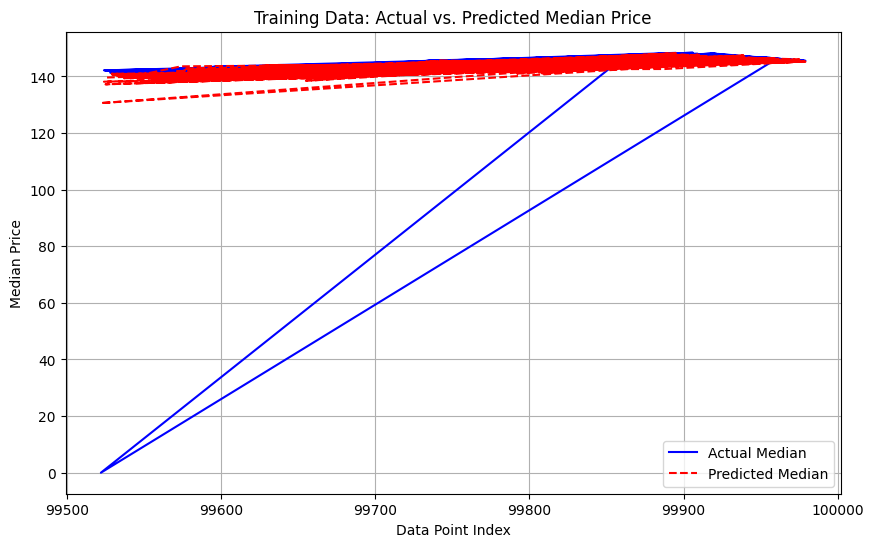

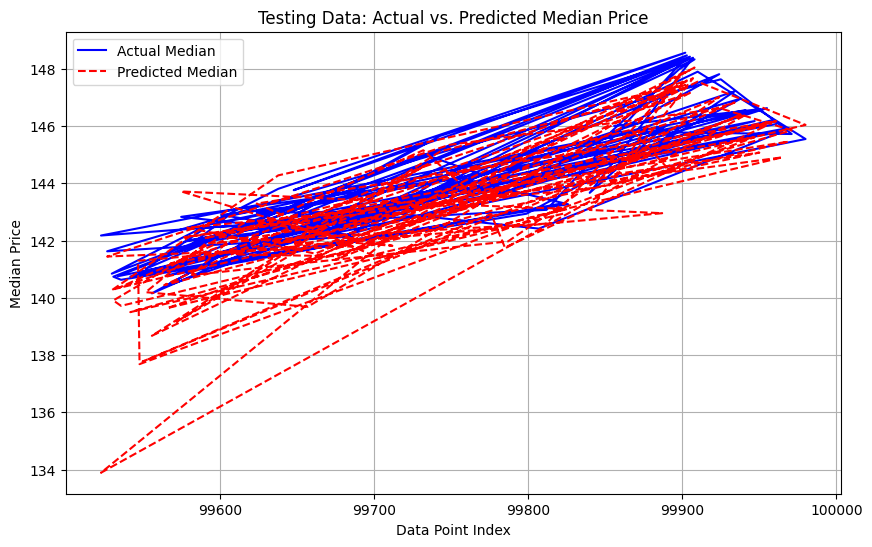

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predictions (Same as before)
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 2. Training Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_train.index, y_train_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Training Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Testing Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_test.index, y_test_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Testing Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 1. Calculate Performance Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_explained_variance = explained_variance_score(y_train, y_train_pred)
test_explained_variance = explained_variance_score(y_test, y_test_pred)

# 2. Store Metrics in a Dictionary
performance_metrics = {
    "train_mse": train_mse,
    "test_mse": test_mse,
    "train_rmse": train_rmse,
    "test_rmse": test_rmse,
    "train_mae": train_mae,
    "test_mae": test_mae,
    "train_r2": train_r2,
    "test_r2": test_r2,
    "train_explained_variance": train_explained_variance,
    "test_explained_variance": test_explained_variance
}

# 3. Get Features and Model Name
features = list(X.columns)
model_name = f"{model_version}_Ensemble Model (Linear SVR + SFN)_{extracted_date}"  # Update model name

# 4. (Optional) Scaling Parameters - If you used scaling, include this part
scaling_parameters = {
    "mean": scaler.mean_.tolist(),
    "std_dev": scaler.scale_.tolist()
}

# 5. Create Log Data Dictionary
log_data = {
    "model_name": model_name,
    "features": features,
    "performance_metrics": performance_metrics,
    "scaling_parameters": scaling_parameters  # Include if you have scaling parameters
}

# 6. Save to JSON File
# Assuming 'extracted_date' is defined earlier in your code
with open(f"{model_name}_log_{extracted_date}.json", "w") as f:
    json.dump(log_data, f, indent=4)

print(f"{model_version}_Model log saved to {model_name}_log_{extracted_date}.json")

3.1_Model log saved to 3.1_Ensemble Model (Linear SVR + SFN)_2025.05.17_log_2025.05.17.json


In [30]:
print("Scaling Mean:", ', '.join(map(str, scaler.mean_)))
print("Scaling Standard Deviation:", ', '.join(map(str, scaler.scale_)))

Scaling Mean: 144.00333242506812, 144.15674114441416, 143.85713351498637, 144.01091008174387, 0.29960762942779273, 0.00542073959223472, 0.20825984577222392, 4064.106267029973, 4113.550544959128, 8.524909009404578, 0.2213085638207851, 0.3262801557412118, 0.408114286436382, 0.3721852861035425, -0.004086835153472594, 144.05215369063353, 48.87135969715101, 144.01041416893733, 144.01684741144416
Scaling Standard Deviation: 1.9320471822814511, 1.9365806437299573, 1.9239142792328026, 1.927700548862204, 0.17346377880582303, 0.1531102604875092, 0.12016827245530073, 2121.648457383602, 675.8125520163993, 50.80308519090673, 0.1446912146764952, 0.18711508133585197, 0.22004055271686637, 0.0992397600752732, 0.14717650136902583, 1.883800034546082, 19.168246852695038, 1.9308196555764994, 1.9259037338287681


ONNX file Generation

In [31]:
!pip install --upgrade onnx==1.14.0

  Using cached onnx-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached onnx-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.6 MB)
  Attempting uninstall: onnx
    Found existing installation: onnx 1.18.0
    Uninstalling onnx-1.18.0:
      Successfully uninstalled onnx-1.18.0


In [32]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [33]:
initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features

In [34]:
# Convert weights to a NumPy array before converting to ONNX
ensemble_model.weights = np.array(ensemble_model.weights)

initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features
onnx_model = convert_sklearn(ensemble_model, initial_types=initial_type)
with open(f"{model_version}_ensemble_model_{extracted_date}.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:

# 7. Update Arasaka website

import requests

def is_internet_available():
    """Check if the internet is available by pinging a reliable site."""
    try:
        requests.get("https://www.google.com", timeout=5)
        return True
    except requests.ConnectionError:
        return False

def SendToArasaka(log_data):
    url = "https://arasaka-neural-bastion.onrender.com/api/trading-data"

    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }

    # Ensure lists are sent as actual arrays, NOT JSON strings
    formatted_data = log_data.copy()  # Copy the data to avoid modifying the original

    if isinstance(log_data.get("features"), str):
        try:
            formatted_data["features"] = json.loads(log_data["features"])
        except json.JSONDecodeError:
            return {"success": False, "message": "Invalid JSON format for features"}

    # Extract scaling mean and std_dev from "scaling_parameters"
    if "scaling_parameters" in log_data:
        formatted_data["scaling_mean"] = log_data["scaling_parameters"].get("mean", [])
        formatted_data["scaling_std_dev"] = log_data["scaling_parameters"].get("std_dev", [])

    # Flatten performance metrics
    if "performance_metrics" in log_data:
        formatted_data.update(log_data["performance_metrics"])

    try:
        response = requests.post(url, headers=headers, json=formatted_data)

        if response.status_code in [200, 201]:
            return {
                "success": True,
                "message": "Data successfully sent to Arasaka",
                "response": response.json()
            }
        else:
            return {
                "success": False,
                "message": f"Failed with status {response.status_code}",
                "response": response.text
            }

    except requests.exceptions.RequestException as e:
        return {"success": False, "message": "Request failed", "error": str(e)}

result = SendToArasaka(log_data)
print(result)
